In [ ]:
%matplotlib widget
from helper import *

<div style="font-family: 'Helvetica Neue', Arial, sans-serif;padding: 10px; text-align: center;">


<div style="margin-top: 10px; display: flex;">
    <div style="max-width: 500px; margin-right: auto">
        <img src="./Resources/neura_logo_black.png" alt="Neura Robotics Logo" style="max-width: 100%; height: auto; object-fit: contain;">
    </div>
    <div style="max-width: 600px; margin-left: auto">
        <img src="./Resources/rwth_igmr_de_rgb.png" alt="Neura Robotics Logo" style="max-width: 100%; height: auto; object-fit: contain;">
    </div>
</div>   
<div style="font-family: 'Helvetica Neue', Arial, sans-serif; max-width: 1500px; margin-left: auto; margin-right: auto ">
<h2 style = "text-align: center">Exploiting Redundancies with Predictive Differential Kinematics in Dual-Quaternion-Space for Configuration-optimized and Singularity-robust Trajectory Tracking</h2>
</div>

<div style="margin-bottom: 40px;">
    <!-- Using the logo from the data folder and making it bigger -->
    <img src="./Resources/maira.png" alt="Neura Robotics Logo" style="max-width: 1800px; width: 100%;">
</div>

</div>

# Motivation
---

- Cobot solutions need to be intuitive, easy to use, and easy to program by non-expert users
- **Hand Guiding Mode** preferred
- singularities are an unknown concept for most people
- **long/short path interpolation** orientation interpolation is an unkown concept for most people
- Dual Quaternions provide solutions to these problems
- most common motion controllers known from literature are perceptible to kinematic singularity issues

# Problem Statement
---

code example with pseudo inverse based differential kinematics

$$
 \dot{\theta} = J^{\dagger} (\dot{x} + k_p e) + P\dot{\theta}_0
$$

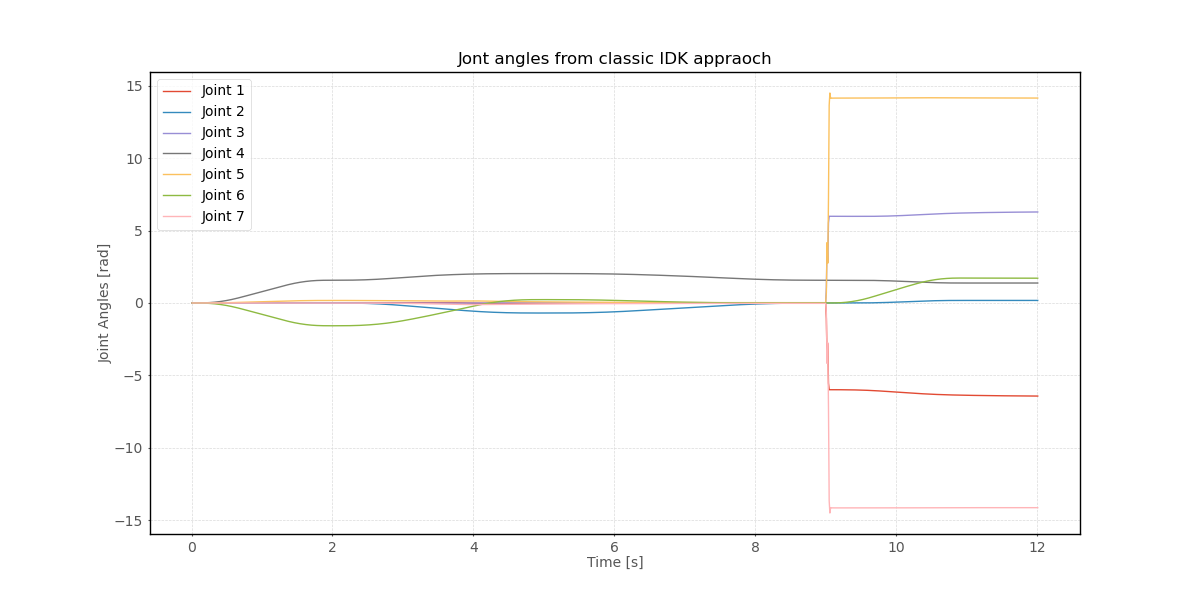

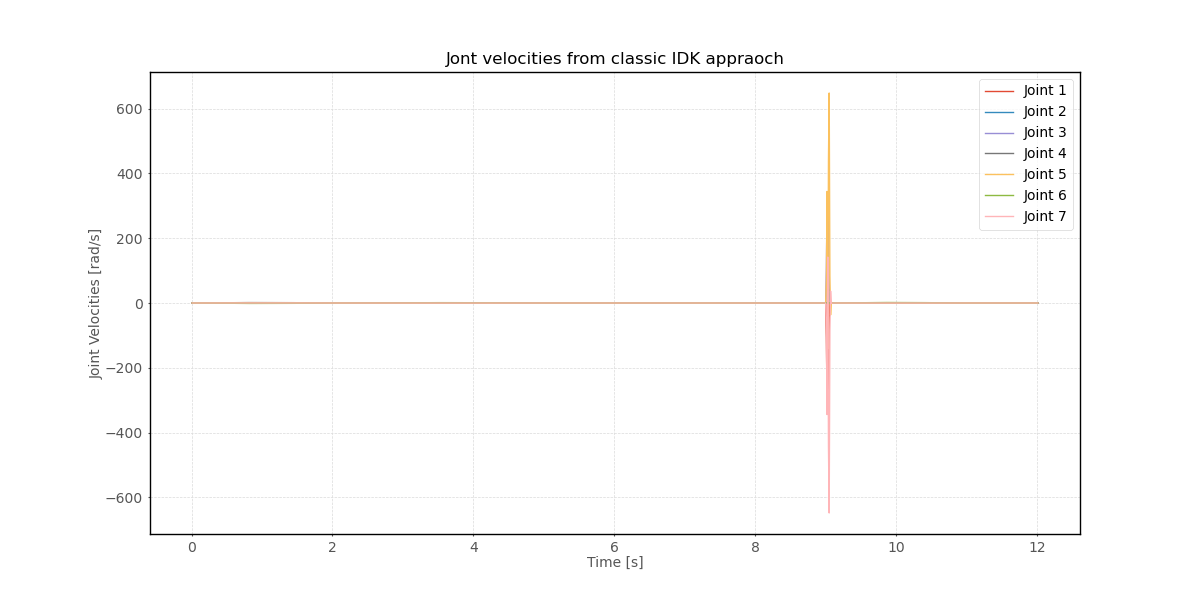

In [3]:
fk = ForwardKinematics()

q1 = np.array([deg2rad(0), deg2rad(0), deg2rad(0), deg2rad(90), deg2rad(10), deg2rad(-90), deg2rad(0)])

quat0 = Quaternion.fromAxisAngle(np.pi*0.5, np.array([0,1,0]))
quat1 = Quaternion.fromAxisAngle(np.pi*0.5, np.array([0,0,1]))

x1 = DualQuaternion.fromQuatPos(quat0, np.array([0.350, 0, 1.138]))
x2 = DualQuaternion.fromQuatPos(quat0, np.array([0.815, 0, 1.138]))
x3 = DualQuaternion.fromQuatPos(quat1*quat0, np.array([0.815, 0, 1.138]))     
x4 = DualQuaternion.fromQuatPos(quat0*quat0, np.array([0.815, 0, 1.138]))  
#x5 = DualQuaternion.fromQuatPos(quat0*quat0, np.array([0, 0, 1.138]))  
#x6 = DualQuaternion.fromQuatPos(quat0*quat0, np.array([0, 0.5, 1.138]))  

task_list = np.array([MoveJoint(q1, 2), MoveLinear(fk.getFK(q1), x1, 3), MoveLinear(x1, x2, 4), MoveLinear(x2, x3, 2), WaitTime(1), MoveLinear(x3, x1, 4),
                      MoveLinear(x1, x2, 4), MoveLinear(x2, x4, 2), WaitTime(1)])
task_list2 = np.array([MoveJoint(q1, 2), MoveLinear(fk.getFK(q1), x1, 3), MoveLinear(x1, x2, 4), MoveLinear(x2, x3, 2), WaitTime(1)])

sim_classic = Simulation(task_list2, method = "classic", browser = "notebook")

sim_classic.start()
plotJointVariables(sim_classic.time_list, sim_classic.q_list, "Jont angles from classic IDK appraoch", "Joint Angles [rad]")
plotJointVariables(sim_classic.time_list, sim_classic.q_dot_list, "Jont velocities from classic IDK appraoch", "Joint Velocities [rad/s]")

# Dual Quaternions
---
Three-dimensional rigid transformations are usually represented by homogeneous transformation matrices $T \in \mathcal{SE}(3)$. The *Special Euclidean Group* $\mathcal{SE}(3)$ is given by the semi-direct product of rotation matrices and translation vectors:

$$
\mathcal{SE}(3) = \mathcal{SO}(3) \ltimes \mathbb{R}^{3}
$$

The unit *Dual Quaternion Space* is then given by the semi-direct product of $\mathcal{S}^3$ and $\mathbb{R}^{3}$: 

$$
\mathbb{H} = \mathcal{S}^3 \ltimes \mathbb{R}^{3}
$$

With the space of unit quaternions $\mathcal{S}^3$ and the translation vectors $\mathbb{R}^{3}$.

# Dual Quaternions
---
A unit dual quaternion $\underline{\xi} \in \mathbb{H}$ can be written as

$$
\underline{\xi} = \hat{r} + \epsilon \frac{1}{2}\bar{t} \otimes \hat{r}
$$

where:
- unit quaternion $\hat{r} \in \mathcal{S}^3$
- pure quaternion $\bar{t} \in \mathbb{R}^{3}$
- dual unit $\epsilon$, with $\epsilon^2 = 0$ and  $\epsilon \neq 0$.

In [2]:
r = Quaternion(0.7071, 0.7071, 0, 0)
t = Quaternion(0, 1, 2, 0)

dual_quaternion = DualQuaternion(r, 0.5*t*r)
print(dual_quaternion)

DualQuaternion(Real: Quaternion(0.707, 0.707, 0.000, 0.000), Dual: Quaternion(-0.354, 0.354, 0.707, -0.707))


# Dual Quaternions: Advantages
---

Dual Quaternions inherit benefitial properties from the quaternions. 

These properties include:
- The **Double Cover Property** (or *Antipodal Property*)
- The **Singularity Free Representation**
- The **High Efficiency** in representing transformations

In [3]:
#Example: Antipodal Property
q_start = Quaternion(1,0,0,0)
q_target = Quaternion(.900, 0.150, 0.000, 0.15).normalize()
q_target_antipodal = -1.0*q_target

fig, ax = create_3d_plot(q_target)

s_slider = create_slider("s", 0, 0, 1)
x_axis1, y_axis1, z_axis1 = draw_frame(ax, [0,0,0], q_start.asRotationMatrix())
x_axis2, y_axis2, z_axis2 = draw_frame(ax, [0,0,0], q_start.asRotationMatrix())

def update_plot(change):
    global x_axis1, y_axis1, z_axis1
    global x_axis2, y_axis2, z_axis2
    
    x_axis1.remove()
    y_axis1.remove()
    z_axis1.remove()

    x_axis2.remove()
    y_axis2.remove()
    z_axis2.remove()
    
    q_interpolated1 = Quaternion.slerp(q_start, q_target, s_slider.value)    
    q_interpolated2 = Quaternion.slerp(q_start, q_target_antipodal, s_slider.value)  
    
    x_axis1, y_axis1, z_axis1 = draw_frame(ax, [0,0,0], q_interpolated1.asRotationMatrix())
    x_axis2, y_axis2, z_axis2 = draw_frame(ax, [0,0,0], q_interpolated2.asRotationMatrix())

    fig.canvas.draw()
    fig.canvas.flush_events()

    
s_slider.observe(update_plot, names = 'value')

widgets.AppLayout(
    center=fig.canvas,
    footer=widgets.VBox([s_slider]),
    pane_heights=[0, 3, 1]
)

AppLayout(children=(VBox(children=(FloatSlider(value=0.0, description='s', layout=Layout(width='98%'), max=1.0…

# Dual Quaternions: Effeciency Advantages
---

<table style="border-collapse: collapse; width: 80%; margin: 0 auto; font-size: 24px;">
    <thead>
      <tr>
        <th style=" width: 400px; border: 1px solid #d3d3d3; padding: 8px; text-align: center;">Computation</th>
        <th style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">Storage</th>
        <th style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">Multiplications</th>
        <th style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">Additions</th>
        <th style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">Sin/Cos Evaluations</th>
      </tr>
    </thead>
    <tbody>
      <tr>
        <td style=" border: 1px solid #d3d3d3; padding: 8px; text-align: center;">Denavit-Hartenberg Tf.</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">$16$</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">$6$</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">$0$</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">$4$</td>
      </tr>
      <tr>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">Dual Quaternion Tf.</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">$8$</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">$15$</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">$3$</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">$2$</td>
      </tr>
      <tr>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">Dual Quaternion Tf. (revolute)</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">$8$</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">$7$</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">$0$</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">$2$</td>
      </tr>
      <tr>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">Tf. Matrix Multiplication</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">$-$</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">$64$</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">$48$</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">$0$</td>
      </tr>
      <tr>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">Dual Quaternion Multiplication</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">$-$</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">$48$</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">$40$</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">$0$</td>
      </tr>
      <tr>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">DH Forward Kinematics 7DoF</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">$112$</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">$490$</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">$336$</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">$28$</td>
      </tr>
      <tr>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">DQ Forward Kinematics 7DoF</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">$56$</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">$441$</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">$301$</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">$14$</td>
      </tr>
      <tr>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">DQ Forward Kinematics 7DoF (revolute)</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">$56$</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">$385$</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">$280$</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">$14$</td>
      </tr>
    </tbody>
  </table>
  
<p style="text-align:center"><strong>Table</strong>: Operation count comparison between dual quaternion and Denavit-Hartenberg transformation, transformation matrix and dual quaternion multiplication and the forward kinematics respectively. </p>

# Dual Quaternions: Screw Transformation
---
<div style="font-family: 'Helvetica Neue', Arial, sans-serif; display: flex; justify-content: space-between;">

<!-- Left column for text -->
<div style="width: 48%;">

The screw axis $\vec{s} \in \mathbb{R}^6$ is defined from a unit rotation axis $\tilde{r}$ and a position $\vec{p}$

$$ 
\vec{s} = (\tilde{r}, \vec{p} \times \tilde{r}) = (\tilde{r}, \vec{m})
$$

Here, $\vec{m} = \vec{p} \times \tilde{r}$ is called the moment of the line.

As exponent for the screw transformation, the screw axis is often represented by the respective *Pure Dual Quaternion* $\underline{\bar{s}} = (0, \tilde{r}) + \epsilon (0, \vec{m}).$
    
</div>

<!-- Right column for image -->
<div style="width: 48%;">
    <img src="./Resources/screw2.png" alt="calibration scheme" style="max-width: 500px; width: 100%; display: block; margin-left: auto; margin-right: auto;margin-top: 100px;">
    <p style="text-align: center; font-style: italic; margin-top: 10px;">Screw Axis example.</p>
</div>

# Dual Quaternions: Screw Transformation
---
A unit dual quaternion $ \underline{\xi} $ can then be computed from screw parameters with exponential mapping:

$$
\underline{\xi} = e^{\frac{\underline{\theta}}{2}\bar{\underline{s}}} = \cos(\frac{\underline{\theta}}{2}) + \bar{\underline{s}} \sin(\frac{\underline{\theta}}{2})
$$

with dual angle $\underline{\theta} = \theta + \epsilon d$ and pure dual quaternion (dual vector) $\bar{\underline{s}} = (0,\tilde{r}) + \epsilon (0,\vec{m})$.

dual angle:

- $\theta$: Angle of rotation around screw axis
- $d$: translation along screw axis ($d = 0$ for revolute joints)


In [4]:
fig, ax = create_3d_plot()

quaternion_display = create_textbox("screw")

angle_slider = create_slider("theta", 0, -2*np.pi, 2*np.pi)
azimuth_slider = create_slider("azimuth", 0.5, -2*np.pi, 2*np.pi)
elevation_slider = create_slider("elevation",1.2, -np.pi, np.pi)

x_slider = create_slider("x", .2, -1, 1)
y_slider = create_slider("y", .3, -1, 1)
z_slider = create_slider("z", 0, -1, 1)

rotation_axis = create_quiver(ax, [0,0,0], [1,0,0], 1, 'grey', "rotation_axis")
x_axis2, y_axis2, z_axis2 = draw_frame(ax, [0.1,.2,.1], np.eye(3))
dq_frame = DualQuaternion.fromQuatPos(Quaternion(1,0,0,0), [0.1,.2,.1])

rot_axis = ax.plot([-2, 2], [0,0], [0,0], "--", linewidth = 1, c = "k")
moment = ax.plot([0,0], [0,0], [0,0], "--", linewidth = 1, c = "k")

# Update function for the sliders
def update_plot(change):

    global rotation_axis, x_axis2, y_axis2, z_axis2, rot_axis, moment
    rotation_axis.remove()
    x_axis2.remove()
    y_axis2.remove()
    z_axis2.remove()
    rot_axis[0].remove()
    moment[0].remove()
    
    direction = spherical_coordinates(azimuth_slider.value, elevation_slider.value)
    
    # set position vector
    pos = [x_slider.value, y_slider.value, z_slider.value]
    
    screw_axis = DualQuaternion.screwAxis(*direction, *pos)
    
    theta = angle_slider.value
    d = 0.0*angle_slider.value
   
    exponent = DualQuaternion(screw_axis.real*theta, screw_axis.dual*theta + screw_axis.real*d)
    dq = DualQuaternion.exp(0.5*exponent)*dq_frame
    
    # update displays
    quaternion_display.value = str(screw_axis)
    
    # update the drawn vectors and the arc
    rotation_axis = create_quiver(ax, pos, direction,1, 'grey', "rotation_axis")
    
    rot_axis = ax.plot([pos[0]-direction[0]*2, pos[0]+direction[0]*2], [pos[1]-direction[1]*2, pos[1]+direction[1]*2], [pos[2]-direction[2]*2, pos[2]+direction[2]*2], "--", linewidth = 1, c = "black")
    moment = ax.plot([0, pos[0]], [0, pos[1]], [0, pos[2]], "--", linewidth = 1, c = "k")
 
    x_axis2, y_axis2, z_axis2 = draw_frame(ax, dq.getPosition().flatten(), dq.real.asRotationMatrix()*0.5)
    
    fig.canvas.draw()
    fig.canvas.flush_events()


angle_slider.observe(update_plot, names = 'value')
azimuth_slider.observe(update_plot, names='value')
elevation_slider.observe(update_plot, names='value')
x_slider.observe(update_plot, names='value')
y_slider.observe(update_plot, names='value')
z_slider.observe(update_plot, names='value')

widgets.AppLayout(
    center=fig.canvas,
    footer=widgets.VBox([quaternion_display, angle_slider, azimuth_slider, elevation_slider, x_slider, y_slider, z_slider]),
    pane_heights=[0, 2, 1])

AppLayout(children=(VBox(children=(Text(value='', description='screw', layout=Layout(width='98%')), FloatSlide…

# State of the Art: Online Motion Control
---

State of the Art does not provide predictive, real-time applicable, singularity robust motion-controller



<table style="border-collapse: collapse; width: 80%; margin: 0 auto; font-size: 24px;">
    <thead>
      <tr>
        <th style=" width: 400px; border: 1px solid #d3d3d3; padding: 8px; text-align: center;">Feature</th>
        <th style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">analytic IK</th>
        <th style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">iterative IK</th>
        <th style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">IDK (classic)</th>
        <th style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">IDK (QP)</th>
        <th style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">MPC</th>
        <th style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">NMPC</th>
      </tr>
    </thead>
    <tbody>
      <tr>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">real-time applicable</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">yes</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">no</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">yes</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">yes</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">no</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">no</td>
      </tr>
      <tr>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">predictive approach</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">no</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">no</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">no</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">no</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">yes</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">yes</td>
      </tr>
      <tr>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">nullspace projection</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">no</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">yes</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">yes</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">yes</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">yes</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">yes</td>
      </tr>
      <tr>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">extra constraints</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">no</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">no</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">no</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">yes</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">yes</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">yes</td>
      </tr>
      <tr>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">locally smooth</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">no</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">no</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">yes</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">yes</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">yes</td>
        <td style="border: 1px solid #d3d3d3; padding: 8px; text-align: center;">yes</td>
      </tr>
    </tbody>
  </table>
  
<p style="text-align: center;"><strong>Table</strong>: Comparison of common inverse kinematic methods.</p>

# Dual Quaternion Jacobian
---
The relation of the twist and the dual quaternion derivative is written in matrix form with the right hamilton matrix $[\underline{\xi}]_R$.

$$
\begin{align*}
\underline{\dot{\xi}} &= \frac{1}{2} \underline{\bar{\Omega}}_s \otimes \underline{\xi}\\
&= \frac{1}{2} [\underline{\xi}]_R \cdot \underline{\bar{\Omega}}_{s[vec]}
\end{align*}
$$

Substitution of the twist $\vec{\Omega}_s = J_s \dot{\vec{\theta}}$ with the space Jacobian and reformulation yields gives the *Unit Dual Quaternion Jacobian* $J_\mathbb{H}$:

$$
\begin{align*}
\underline{\dot{\xi}} &= \left(\frac{1}{2} [\underline{\xi}]_R J_s \right) \dot{\vec{\theta}}\\
&= J_\mathbb{H}\dot{\vec{\theta}}
\end{align*}
$$

# Predictive Differential Kinematics: Yoshikawa Manipulability Optimization
---

Yoshikawa manipulability Measure:

$$
m(\theta) = \sqrt{\det \left( J(\theta)J(\theta)^T \right)}
$$

Yoshikawa Manipulability gradient: 

$$
\dot{m}(\theta) = \frac{\partial m(\theta)}{\partial \vec{\theta}}\dot{\vec{\theta}} = J_m^T\dot{\vec{\theta}}
$$

with the formulation from Corke and Haviland:

$$
J_m(\theta) = \sqrt{ \det \left( J(\theta)J(\theta)^T \right)}
\begin{bmatrix}
\text{vec}(J(\theta)H_1(\theta)^T)^T \cdot \text{vec}((J(\theta)J(\theta)^T)^{-1}) \\
\text{vec}(J(\theta)H_2(\theta)^T)^T \cdot \text{vec}((J(\theta)J(\theta)^T)^{-1}) \\
\vdots \\
\text{vec}(J(\theta)H_{DoF}(\theta)^T)^T \cdot \text{vec}((J(\theta)J(\theta)^T)^{-1})
\end{bmatrix}
$$

# Predictive Differential Kinematics: Directional Manipulability Optimization
---

The direction is computed from the dual quaternionic body twist, 

$$
 \underline{\dot{\xi}}_{des} = \frac{1}{2} \underline{\xi}_{des} \otimes \underline{\bar{\Omega}}_b
$$

it gives the velocity epressed in the TCP frame.

$$
 dir = \left( o_x, o_y, o_z, t_x, t_y, t_z \right) = \underline{\bar{\Omega}}_{b[6vec]} = 2 \cdot \left[ \underline{\xi}_{des}^*\otimes \underline{\dot{\xi}}_{des}\right]_{6vec}
$$

The directional Gradient can be computed via weighing and regularization of the classic formulation of the manipulability gradient:

$$
J_{dir}(\theta) = 
\begin{bmatrix}
\text{vec}(\color{red}{W_{dir}}\color{black}{} J(\theta)H_1(\theta)^T)^T \cdot \text{vec}((J(\theta)J(\theta)^T  + \color{blue}{\lambda I}\color{black}{})^{-1}) \\
\text{vec}(\color{red}{W_{dir}}\color{black}{} J(\theta)H_2(\theta)^T)^T \cdot \text{vec}((J(\theta)J(\theta)^T + \color{blue}{\lambda I}\color{black}{})^{-1}) \\
\vdots \\
\text{vec}(\color{red}{W_{dir}}\color{black}{} J(\theta)H_{DoF}(\theta)^T)^T \cdot \text{vec}((J(\theta)J(\theta)^T + \color{blue}{\lambda I}\color{black}{})^{-1}) 
\end{bmatrix}
$$

# Predictive Differential Kinematics: Prediction
---
The direction (body twist) is computed for future timesteps:

$$
\begin{align*}
dir_{pred}(t) &= \frac{ dir_0 +  \sum_{i=0}^{n} \left| 2 \left[ \underline{\xi}_{des}^*(t + i \Delta t)\otimes \underline{\dot{\xi}}_{des}(t + i \Delta t)\right]_{6vec}\right|}{ \left\| dir_0 + \sum_{i=0}^{n} 2 \left[ \underline{\xi}_{des}^*(t + i \Delta t)\otimes \underline{\dot{\xi}}_{des}(t + i \Delta t)\right]_{6vec}\right\|} \\
\\
&= \frac{ dir_0 +  \sum_{i=0}^{n} \left| dir(t + i \Delta t)\right|}{ \left\| dir_0 +  \sum_{i=0}^{n} dir(t + i \Delta t)\right\|} 
\end{align*}
$$

# Predictive Differential Kinematics: proposed Method
---

$$
\begin{align*}
\min_{x} \; f(x) = &\frac{1}{2} 
\begin{bmatrix}
\dot{\theta}\\
\ddot{\theta}\\
s
\end{bmatrix}^T 
\begin{bmatrix}
W_{\dot{\theta}} & 0 & 0\\
0 & W_{\ddot{\theta}} & 0\\
0 & 0 & \lambda_s
\end{bmatrix}
\begin{bmatrix}
\dot{\theta}\\
\ddot{\theta}\\
s
\end{bmatrix} + 
\begin{bmatrix}
(W_p \theta + \lambda_l J_l(\theta) - \lambda_{dir}J_{dir}(\theta, dir))\\
W_v \dot{\theta} \\
-2\lambda_s
\end{bmatrix}^T 
\begin{bmatrix}
\dot{\theta}\\
\ddot{\theta}\\
s
\end{bmatrix}\\
\\
\textrm{subject to}& \; 
\begin{bmatrix}
0_{8 \times 1}\\
\dot{\theta}_{k-1}\\
\dot{\theta}_m\\
-inf\\
0
\end{bmatrix} 
\leq 
\begin{bmatrix}
J_\mathbb{H}(\theta) & 0_{8 \times DoF} &-[\dot{\underline{\xi}}_{des} + k_p\left(\underline{\xi}_{des} - fk(\theta)\right)]_{vec}\\
I_{DoF \times DoF} & -\Delta t I_{DoF \times DoF} & 0_{DoF \times 1}\\
I_{DoF \times DoF} & 0_{DoF \times DoF} & 0_{DoF \times 1}\\
0_{DoF \times DoF} & I_{DoF \times DoF} & 0_{DoF \times 1}\\
0_{1 \times DoF} & 0_{1 \times DoF} & 1\\
\end{bmatrix} 
\begin{bmatrix}
\dot{\theta}\\
\ddot{\theta}\\
s
\end{bmatrix} \leq 
\begin{bmatrix}
0_{8 \times 1}\\
\dot{\theta}_{k-1}\\
\dot{\theta}_M\\
inf\\
1
\end{bmatrix} 
\end{align*}
$$

# Predictive Differential Kinematics: Proposed Method with Yoshikawa Manipulability Gradient
---


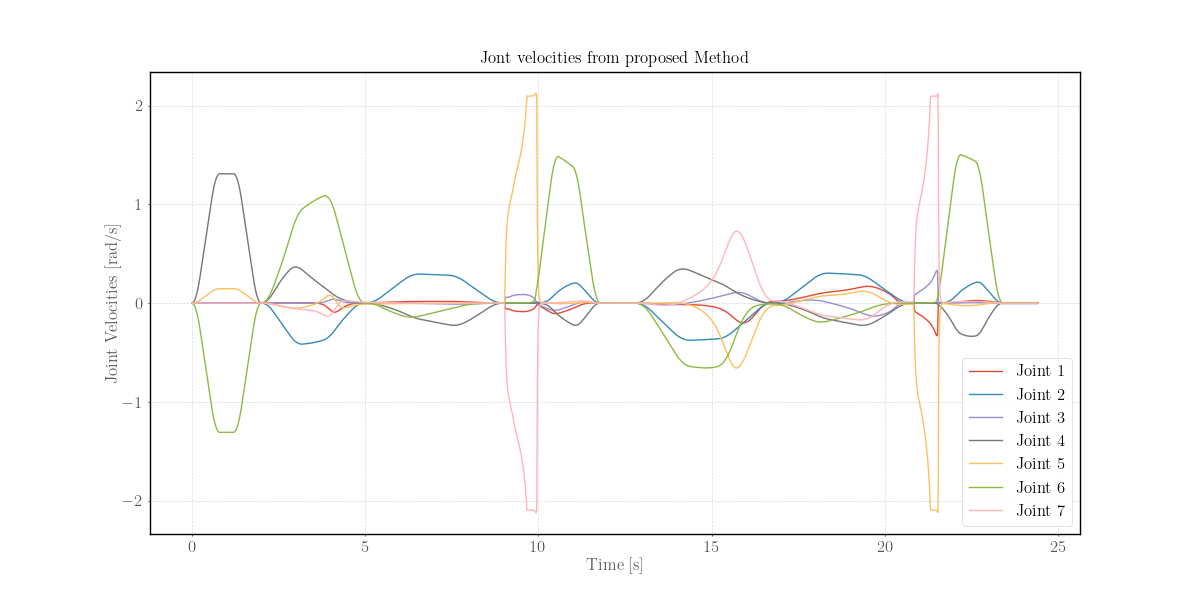

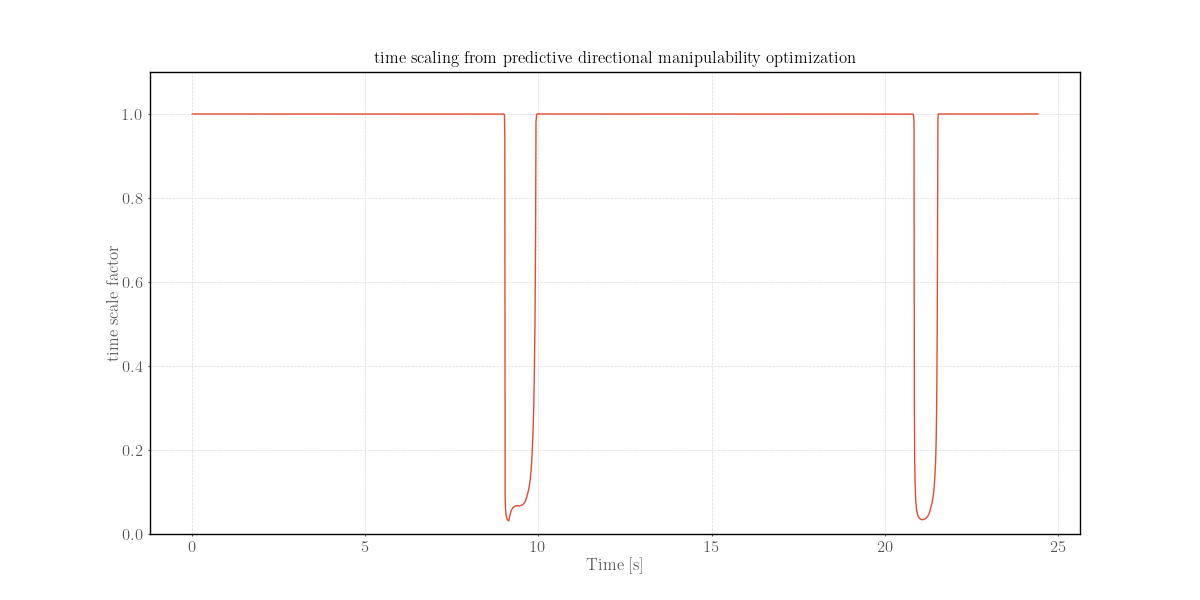

In [14]:
sim_yosh = Simulation(task_list, method = "qp_yoshikawa", browser = "notebook")

sim_yosh.start()

plotJointVariables(sim_yosh.time_list, sim_yosh.q_dot_list, "Jont velocities from proposed Method", "Joint Velocities [rad/s]")
plotTimeScale(sim_yosh.time_list, sim_yosh.time_scale_list, "time scaling from predictive directional manipulability optimization")

# Predictive Differential Kinematics: Proposed Method with proposed *Directional Manipulability Gradient*
---


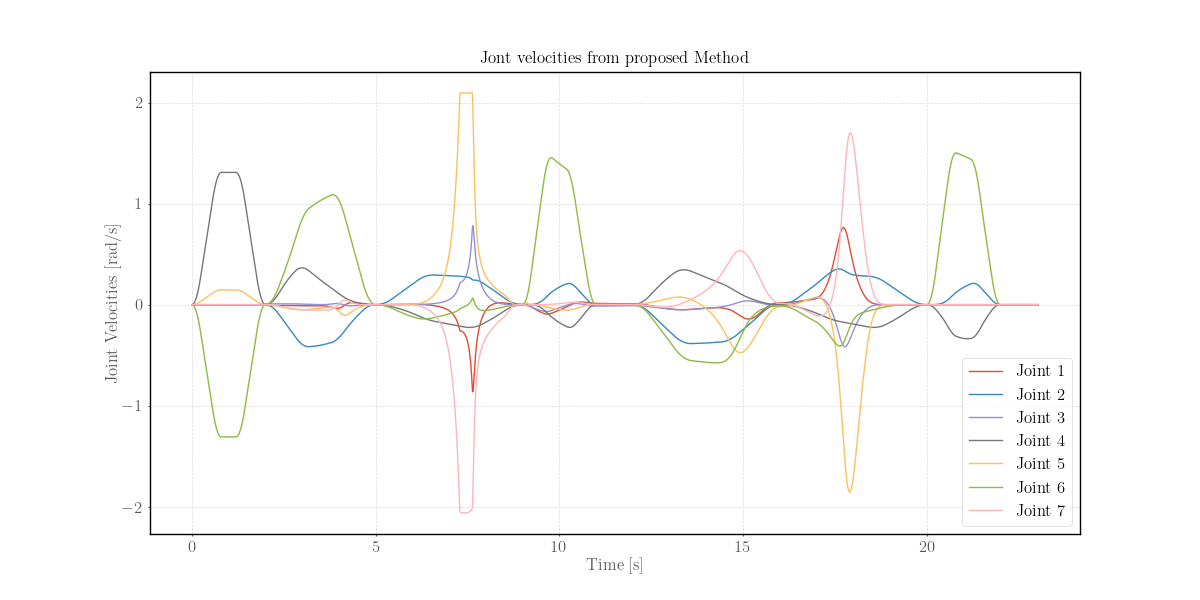

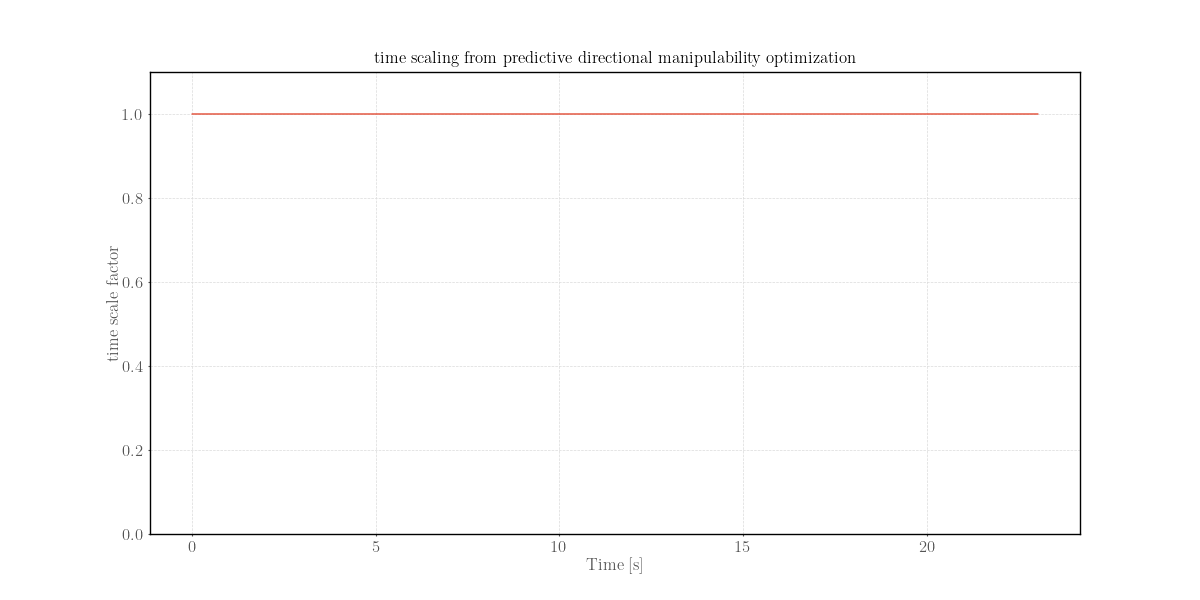

In [15]:
sim_qp = Simulation(task_list, method = "qp", browser = "notebook")

sim_qp.start()

plotJointVariables(sim_qp.time_list, sim_qp.q_dot_list, "Jont velocities from proposed Method", "Joint Velocities [rad/s]")
plotTimeScale(sim_qp.time_list, sim_qp.time_scale_list, "time scaling from predictive directional manipulability optimization")

# Dual Quaternion Interpolation: Proposed Method
---
- Dual-Quaternion-Quintic-Blends (DQQB)
- multi-point interpolation in the dual quaternion space with definable motion primitives (line, arc)
- can make use of the benefits dual quaternionic contemplation
- provides smooth, velocity, acceleration, and jerk limited trajectories for rotational and translational motion
- Publication currently under review, for further details see: https://github.com/JTem/Dual-Quaternion-Quintic-Blends

  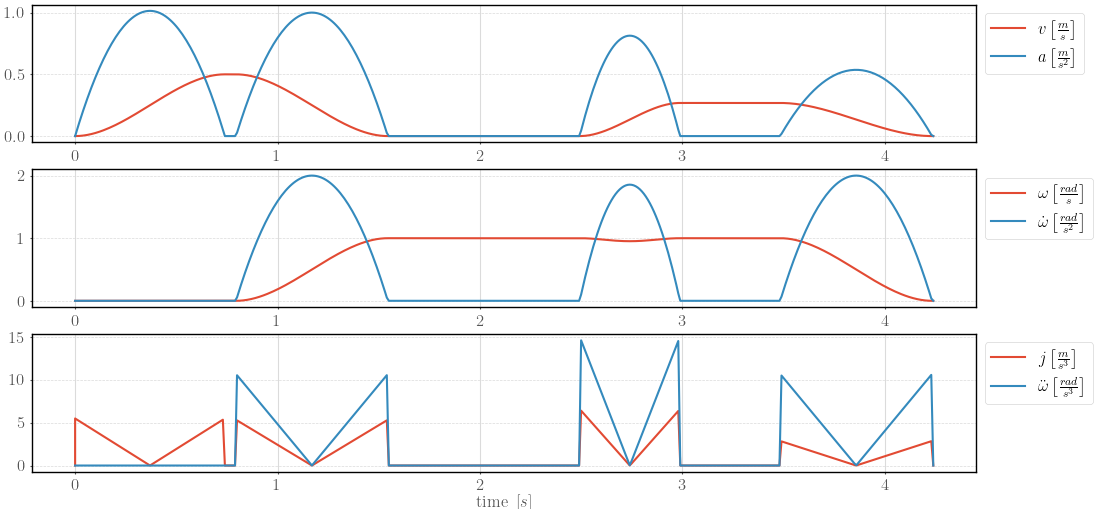

# Dual Quaternion Interpolation: DQQB
---

In [6]:
%%HTML
<video width="1100" height="700" controls>
  <source src=".\Resources\example.mov" type="video/mp4">
</video>

# Conclusion
---
- Dual Quaternion + screw theory efficiency provides **42-76% faster** kinematics algorithms when compared to DH implementation
- **real-time applicable predictive motion controller**
- directional manipulability **reduces velocity spikes by up to 17%** on non-singular trajectories
- double cover property enables distinction between long and short-path orientation interpolation
- **enhanced intuition** because of the dual quaternion double cover property for non-expert users via handguiding mode
- no representative singularities